This notebook has been used to join together the datasets of Viasat with that of Nis to try to understand the relation between the number of parked cars and the number of parking fines in the same area

In [1]:
import warnings, numpy as np, pandas as pd, pymysql, matplotlib, matplotlib.pyplot as plt, seaborn as sb, geopandas as gp, geopy
from datetime import datetime, timedelta

In [2]:
def binner(x):
    h = int(x.strftime('%H'))
    d = int(x.strftime('%w'))
    
    if h >= 4 and h < 15:
        h = 1
    elif h >= 15 and h < 21:
        h = 2
    else:
        h = 3
        
    if d == 0 or d == 6:
        # restday
        d = 1
    else:
        # weekday
        d = 2
        
    
    
    return "%d%d" % (d,h)

In [3]:
multe = pd.read_csv("data/multe_pos.csv", parse_dates=["date"])
park = pd.read_csv("data/June_2017_correct.csv", parse_dates=["date"])

multe = multe.rename({'num':'num_multe'}, axis=1).drop('via', axis = 1).dropna()
multe['datebin'] = multe['date'].apply(binner)
multe = multe.loc[:, ["datebin", "long", "lat", "num_multe"]].copy()
multe.loc[:,["long", "lat"]] = multe.loc[:,["long", "lat"]].round(4)

park = park.rename({'num':'num_park'}, axis=1)
park['datebin'] = park['date'].apply(binner)
park = park.loc[:, ["datebin", "long", "lat", "num_park"]].copy()
park.loc[:,["long", "lat"]] = park.loc[:,["long", "lat"]].round(4)

""

''

In [4]:
park.num_park.sum()

5122109

In [5]:
park.head()


,datebin,long,lat,num_park
0,23,7.6035,45.029,1
1,23,7.6035,45.067,1
2,23,7.6035,45.079,2
3,23,7.6205,45.048,1
4,23,7.6205,45.054,1


In [6]:
multe.head()

,datebin,long,lat,num_multe
0,23,7.6487,45.0438,1
1,23,7.6485,45.0439,1
2,23,7.6487,45.0438,1
3,23,7.6487,45.0438,1
4,23,7.6483,45.0439,1


In [7]:
#pd.date_range(np.min(park['date']), np.max(park['date']), periods=12, freq='H')

#create the data bins from the data (already binned in the dataset)
(_, longbins) = pd.cut(park['long'], 20, retbins=True)
(_, latbins) = pd.cut(park['lat'], 20, retbins=True)

park.head()

,datebin,long,lat,num_park
0,23,7.6035,45.029,1
1,23,7.6035,45.067,1
2,23,7.6035,45.079,2
3,23,7.6205,45.048,1
4,23,7.6205,45.054,1


In [8]:
multe['long'] = pd.to_numeric(pd.cut(multe['long'], bins=longbins).apply(lambda x: (x.left+x.right)/2))
multe['lat'] = pd.to_numeric(pd.cut(multe['lat'], bins=latbins).apply(lambda x: (x.left+x.right)/2))

multe.head()

,datebin,long,lat,num_multe
0,23,7.648,45.042,1
1,23,7.648,45.042,1
2,23,7.648,45.042,1
3,23,7.648,45.042,1
4,23,7.648,45.042,1


In [9]:
multe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35327 entries, 0 to 40326
Data columns (total 4 columns):
datebin      35327 non-null object
long         35315 non-null float64
lat          35310 non-null float64
num_multe    35327 non-null int64
dtypes: float64(2), int64(1), object(1)
memory usage: 1.3+ MB


In [10]:
multe.head()

,datebin,long,lat,num_multe
0,23,7.648,45.042,1
1,23,7.648,45.042,1
2,23,7.648,45.042,1
3,23,7.648,45.042,1
4,23,7.648,45.042,1


In [11]:
print(multe.size)
multe = multe.groupby(["datebin","long","lat"]).agg({"num_multe":'sum'}).reset_index()
multe = multe.set_index(["datebin","long","lat"], drop=True)

print(multe.size)
multe

141308
774


num_multe
datebin long   lat              
11      7.6075 45.072          8
        7.6160 45.060          1
               45.072          5
               45.084          4
               45.102          1
        7.6240 45.012          1
               45.042          4
               45.066          4
               45.072          4
               45.078         16
               45.084          1
        7.6320 45.018          4
               45.036          3
               45.042          8
               45.048         11
               45.060          1
               45.066          4
               45.072          4
               45.078          4
               45.084          2
        7.6400 45.018          1
               45.024          8
               45.030          1
               45.036          1
               45.042          3
               45.048         25
               45.054          1
               45.060          5
               45.066          1
               45.072          7
...                          ...
23      7.6800 45.096          1
               45.102          3
        7.6885 45.030          4
               45.042         14
               45.054          6
               45.060        105
               45.066        266
               45.072         17
               45.078          1
               45.084          4
               45.090          6
               45.096          6
               45.102          4
        7.6970 45.060         34
               45.066         73
               45.072          6
               45.078          2
               45.084          2
               45.090         15
               45.096         23
               45.102          3
        7.7050 45.054          4
               45.066          2
               45.072          3
               45.084          1
               45.090         13
        7.7130 45.066          2
               45.072          1
        7.7210 45.072          3
               45.102          2

[774 rows x 1 columns]

In [12]:
print(park.size)
park = park.groupby(["datebin","long","lat"]).agg({"num_park":'sum'}).reset_index()
park = park.set_index(["datebin","long","lat"], drop=True)

print(park.size)
park

975596
2313


num_park
datebin long   lat              
11      7.6035 44.9970       322
               45.0035      1234
               45.0100       781
               45.0160       135
               45.0225       174
               45.0290       550
               45.0350        62
               45.0415        25
               45.0480         6
               45.0540       168
               45.0605       164
               45.0670      1040
               45.0730      3132
               45.0790      1370
               45.0980        52
               45.1045        31
               45.1170       147
        7.6120 44.9970       118
               45.0035        16
               45.0100        10
               45.0160       794
               45.0225      1103
               45.0290       154
               45.0350       169
               45.0415       442
               45.0480       171
               45.0540      2194
               45.0605      2075
               45.0670      1680
               45.0730      2913
...                          ...
23      7.7570 45.0225       600
               45.0290       143
               45.0350         6
               45.0480       733
               45.0540       224
               45.0605         4
               45.0670        14
               45.0730         3
               45.0920       374
               45.0980       836
               45.1045      2745
               45.1110      1849
               45.1170        75
        7.7655 44.9970       116
               45.0035       344
               45.0100       252
               45.0160        86
               45.0225       115
               45.0290       136
               45.0350        80
               45.0415       616
               45.0480       127
               45.0540        13
               45.0605       108
               45.0790       366
               45.0920        65
               45.0980       841
               45.1045       884
               45.1110       268
               45.1170        15

[2313 rows x 1 columns]

In [13]:
multe.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 774 entries, (11, 7.6075, 45.072) to (23, 7.721, 45.102)
Data columns (total 1 columns):
num_multe    774 non-null int64
dtypes: int64(1)
memory usage: 8.9+ KB


In [14]:
joined = multe.join(park, how="outer")

joined = joined.sort_values("num_multe", ascending=False).fillna(0)

joined.head()

num_multe  num_park
datebin long  lat                        
21      7.672 45.066     1001.0       0.0
              45.078      940.0       0.0
        7.664 45.072      885.0       0.0
              45.078      778.0       0.0
        7.672 45.072      735.0       0.0

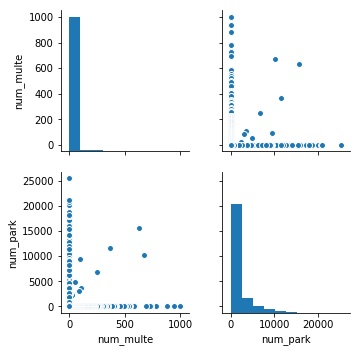

In [15]:
sb.pairplot(joined)

In [16]:
joined = joined.reset_index()
joined.head()

,datebin,long,lat,num_multe,num_park
0,21,7.672,45.066,1001.0,0.0
1,21,7.672,45.078,940.0,0.0
2,21,7.664,45.072,885.0,0.0
3,21,7.664,45.078,778.0,0.0
4,21,7.672,45.072,735.0,0.0


In [17]:
joined.long = pd.cut(joined.long, 20, labels=range(20))
joined.lat = pd.cut(joined.lat, 20, labels=range(20))

In [18]:
j2 = joined.datebin.str.extract('(?P<day>\d)(?P<hour>\d)', expand=True)
joined1 = pd.concat([joined, j2], axis=1)
joined1.drop('datebin', axis=1, inplace=True)

joined1.head()

,long,lat,num_multe,num_park,day,hour
0,8,11,1001.0,0.0,2,1
1,8,13,940.0,0.0,2,1
2,7,12,885.0,0.0,2,1
3,7,13,778.0,0.0,2,1
4,8,12,735.0,0.0,2,1


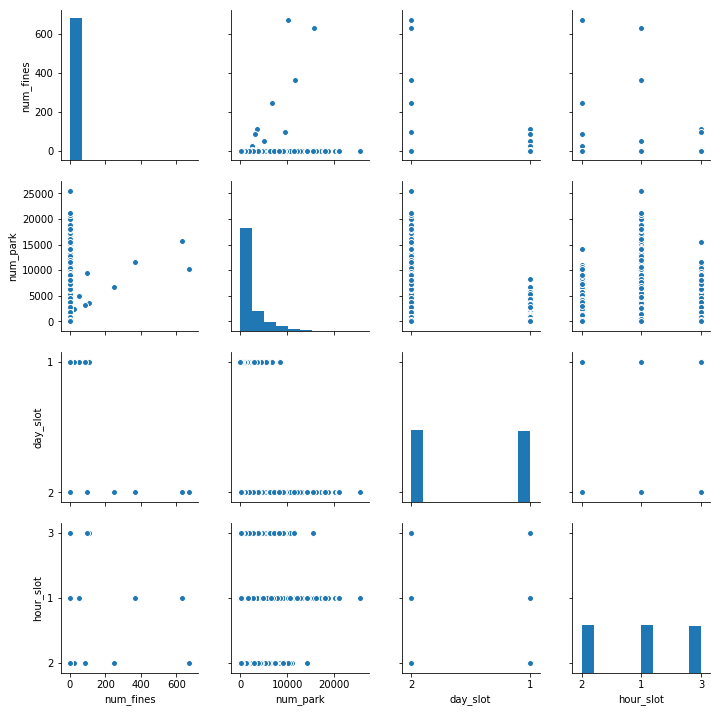

In [24]:
t=joined1
t = t.drop(["long", "lat"], axis=1)
t.columns = ['num_fines', 'num_park', 'day_slot', 'hour_slot']
sb.pairplot(t.loc[t.num_park > 0])


In [25]:
joined1.loc[joined1.num_park > 0].groupby(["day","hour"]).count()

long  lat  num_multe  num_park
day hour                                
1   1      384  384        384       384
    2      381  381        381       381
    3      378  378        378       378
2   1      394  394        394       394
    2      391  391        391       391
    3      385  385        385       385

In [26]:
joined2 = joined1
joined2['long'] = pd.to_numeric(joined2['long'])
joined2['lat'] = pd.to_numeric(joined2['lat'])
joined2['day'] = pd.to_numeric(joined2['day'])
joined2['hour'] = pd.to_numeric(joined2['hour'])
corrmat = joined1.corr()
corrmat
joined2.head()

,long,lat,num_multe,num_park,day,hour
0,8,11,1001.0,0.0,2,1
1,8,13,940.0,0.0,2,1
2,7,12,885.0,0.0,2,1
3,7,13,778.0,0.0,2,1
4,8,12,735.0,0.0,2,1


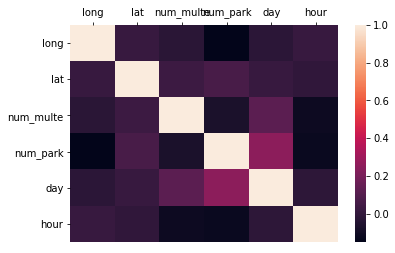

In [27]:
sb.heatmap(corrmat, vmax=1., square=False).xaxis.tick_top()

In [28]:
joined3 = joined2
joined3['squarebin'] = pd.to_numeric(joined2.apply(lambda x: "%02d%02d" % (x.lat, x.long), axis=1))

joined3.sum()

long           27093.0
lat            30418.0
num_multe      37375.0
num_park     5122109.0
day             4706.0
hour            6016.0
squarebin    3068893.0
dtype: float64

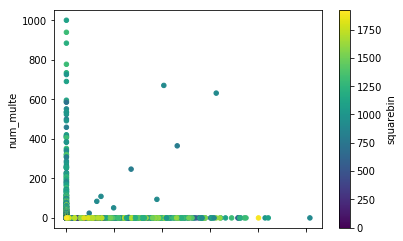

In [29]:
joined3.plot.scatter(x='num_park', y='num_multe', c='squarebin', colormap='viridis')

In [30]:
j4 = joined3.loc[joined3['num_park'] < 1]
j4.head()
#j4.plot.scatter(x='num_park', y='num_multe', c='squarebin', colormap='viridis')
joined3.sort_values("num_park", ascending=False)

,long,lat,num_multe,num_park,day,hour,squarebin
2059,7,9,0.0,25426.0,2,1,907
2081,8,11,0.0,21078.0,2,1,1108
2080,8,10,0.0,20751.0,2,1,1008
2009,4,19,0.0,20057.0,2,1,1904
2063,7,13,0.0,18753.0,2,1,1307
2043,6,13,0.0,18590.0,2,1,1306
2039,6,9,0.0,18198.0,2,1,906
2082,8,12,0.0,18099.0,2,1,1208
2062,7,12,0.0,18051.0,2,1,1207
2042,6,12,0.0,17952.0,2,1,1206
